In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

from tensorflow import keras
from keras.models import Model
from keras.layers import *
from keras.utils import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
# from nltk.translate.bleu_score import sentence_bleu

In [2]:
from tensorflow.keras import backend 
from tensorflow.keras import utils

In [3]:
df_full = pd.read_csv('data/PHOENIX-2014-T.train.corpus.csv', sep='|')

In [4]:
df = df_full.drop(columns=['name','video','start','end','speaker'])
df.columns

Index(['orth', 'translation'], dtype='object')

In [5]:
df.shape

(7096, 2)

In [6]:
df.describe()

,orth,translation
count,7096,7096
unique,6900,6853
top,SCHOEN ABEND TSCHUESS,guten abend liebe zuschauer
freq,22,63


In [7]:
df.iloc[1]['orth']

'ORT REGEN DURCH REGEN KOENNEN UEBERSCHWEMMUNG KOENNEN'

In [8]:
df.iloc[1]['translation']

'mancherorts regnet es auch länger und ergiebig auch lokale überschwemmungen sind wieder möglich'

In [9]:
data_size = df.shape[1]
input_texts = df['translation']
target_texts = df['orth']
target_texts = ['<Start> ' + text + ' <End>' for text in target_texts]

In [10]:
input_texts[1]

'mancherorts regnet es auch länger und ergiebig auch lokale überschwemmungen sind wieder möglich'

In [11]:
target_texts[1]

'<Start> ORT REGEN DURCH REGEN KOENNEN UEBERSCHWEMMUNG KOENNEN <End>'

In [12]:
target_texts = [text.replace('-', ' - ') for text in target_texts]

umlaut_dict = {'AE': 'Ä',
               'OE': 'Ö',
               'UE': 'Ü'}
for key in umlaut_dict.keys():
    target_texts = [text.replace(key, umlaut_dict[key]) for text in target_texts]

In [14]:
d_input = {}
for s in input_texts:
    words = s.split(' ')
    for w in words:
        if w in d_input.keys():
            d_input[w]+= 1
        else:
            d_input[w] = 1
sd = sorted(d_input, key=d_input.get)
sd.reverse()
print("Unique words: ",len(sd),", Total words: ",sum(d_input.values()))
for s in sd:
    print(s, d_input[s])

Unique words:  2887 , Total words:  99081
und 4156
im 2934
es 2852
der 2462
am 2197
in 1938
die 1865
auch 1747
grad 1588
bis 1526
den 1429
morgen 1292
nacht 1042
noch 974
an 962
regen 838
heute 838
sich 825
wolken 823
ein 747
süden 742
sonne 740
norden 737
ist 722
wird 709
für 661
das 649
schauer 606
mit 604
von 582
aber 579
westen 579
dann 573
sonst 546
tag 498
wind 489
da 484
osten 483
wieder 474
auf 465
mal 461
über 460
teilweise 454
gewitter 453
aus 439
vor 436
zum 416
oder 403
nur 395
wettervorhersage 390
nun 387
etwas 385
schnee 385
hier 370
meist 367
wetter 361
abend 359
regnet 352
gibt 348
nordwesten 343
uns 334
bleibt 331
allem 315
nach 311
minus 306
zu 301
bei 296
freitag 287
sind 286
teil 282
richtung 279
weht 269
dabei 267
freundlich 265
dem 262
donnerstag 260
südosten 254
sonntag 252
samstag 249
dort 245
luft 241
werden 239
trocken 236
nebel 235
nordsee 234
mittwoch 227
temperaturen 227
südwesten 226
kann 218
mäßig 214
schon 209
einzelne 207
nordosten 206
wir 204
so 204
mo

In [134]:
d_target = {}
for s in target_texts:
    words = s.split(' ')
    for w in words:
        if w in d_target.keys():
            d_target[w]+= 1
        else:
            d_target[w] = 1
sd = sorted(d_target, key=d_target.get)
sd.reverse()
print("Unique words: ",len(sd),", Total words: ",sum(d_target.values()))
for s in sd:
    print(s, d_target[s])

Unique words:  977 , Total words:  72661
<End> 7096
<Start> 7096
REGEN 2157
REGION 1885
- 1611
IX 1505
KOMMEN 1326
MORGEN 1266
NORD 1218
SONNE 1143
WOLKE 1109
GRAD 1052
NACHT 871
SÜD 835
KÖNNEN 817
AUCH 786
SCHNEE 769
MEHR 768
BISSCHEN 751
HEUTE 748
BIS 696
GEWITTER 674
WETTER 669
WIND 637
WEHEN 581
ZWANZIG 536
OST 532
DANN 531
WEST 486
SCHAÜR 477
WIE 455
MÖGLICH 433
ABEND 430
NEBEL 419
FREUNDLICH 418
BERG 415
JETZT 414
NORDWEST 408
ABER 386
STURM 385
TAG 378
TEIL 349
AUSSEHEN 346
TIEF 328
MINUS 320
FLUSS 320
SÜDOST 314
MITTE 310
WECHSELHAFT 303
KLAR 301
VIEL 299
SONNTAG 295
SCHWACH 294
KÜHL 291
FREITAG 290
TROCKEN 289
SAMSTAG 280
STARK 275
HOCH 274
MÄSSIG 270
BESONDERS 269
SONST 262
DONNERSTAG 262
IN 257
MEISTENS 254
UND 252
BLEIBEN 250
KOMMEND 247
KALT 242
MITTWOCH 232
MONTAG 225
LAND 223
WARM 223
TEMPERATUR 221
NORDOST 219
NUR 219
FÜNF 217
SÜDWEST 217
ALPEN 215
DEUTSCH 206
GUT 201
MITTAG 197
DIENSTAG 197
EINS 194
IM 192
KÜSTE 190
FROST 187
ZWEI 187
SCHÖN 186
DREI 184
neg 175
MILD 17

In [85]:
target_texts[0]

'<Start> JETZT WETTER MORGEN DONNERSTAG ZWÖLF FEBRUAR <End>'

In [135]:
input_texts_split = [text.split() for text in input_texts]
target_texts_split = [text.split() for text in target_texts]

input_texts_split = [[('<Unknown>' if d_input[w] == 1 else w) for w in text] for text in input_texts_split]
target_texts_split = [[('<Unknown>' if d_target[w] == 1 else w) for w in text] for text in target_texts_split]
        

input_words = sorted(set([word for text in input_texts_split for word in text]))
target_words = sorted(set([word for text in target_texts_split for word in text]))

num_input_words = len(input_words)
num_target_words = len(target_words)

input_word_index = {word: ind+1 for ind,word in enumerate(input_words)}
input_word_index[''] = 0
target_word_index = {word: ind+1 for ind,word in enumerate(target_words)}
target_word_index[''] = 0
#0 ce predstavljati praznina zbog paddovanja

inverted_input_word_index = {value: key for key,value in input_word_index.items()}
inverted_target_word_index = {value: key for (key,value) in target_word_index.items()}

max_input_seq_len = np.max([len(text) for text in input_texts_split])
max_target_seq_len = np.max([len(text) for text in target_texts_split])

#Pregled najduzih recenica inputa i targeta
#print(input_texts[np.argmax([len(text) for text in input_texts_split])])
#print(target_texts[np.argmax([len(text) for text in target_texts_split])]) #Ista recenica

input_pad_len = max_input_seq_len
target_pad_len = max_target_seq_len 
#Treba ova 2 staviti na vecu vrednost da bi model radio sa duzim recenicama


In [171]:
target_texts[12]

'<Start> LANG ZEIT REGION HOCH KOMMEN OST KOMMEN SONST REGION DEUTSCH STARK RUHIG AUCH TEILWEISE FREUNDLICH SONNE <End>'

In [137]:
encoder_input_data = []
for text in input_texts_split:
    encoder_input_data.append([input_word_index.get(word, 0) for word in text])
encoder_input_data = pad_sequences(encoder_input_data, input_pad_len, padding = 'post')

decoder_input_data = []
decoder_output_data = []
for text in target_texts_split:
    decoder_input_data.append([target_word_index.get(word, 0) for word in text])
    decoder_output_data.append([target_word_index.get(word,0) for word in text[1:]]) 
decoder_input_data = pad_sequences(decoder_input_data, target_pad_len, padding = 'post')
decoder_output_data = pad_sequences(decoder_output_data, target_pad_len, padding = 'post')

In [138]:
encoder_input_data.shape

(7096, 52)

In [139]:
decoder_input_data.shape

(7096, 36)

In [140]:
decoder_output_data.shape

(7096, 36)

In [141]:
embedding_size = 300

input_word_embeddings = {}
target_word_embeddings = {}
with open('glove-embedding/vectors.txt', 'r', encoding = 'utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype = 'float32')
        input_word_embeddings[word] = coefs
        target_word_embeddings[word.upper()] = coefs

In [142]:
oov_words_input = []
for word in input_words:
    if not word in input_word_embeddings:
        oov_words_input.append(word)

In [143]:
oov_words_target = []
for word in target_words:
    if not word in target_word_embeddings:
        oov_words_target.append(word)

In [144]:
input_embedding_matrix = np.zeros((num_input_words + 1, embedding_size))
for i in range(num_input_words):
    input_embedding_matrix[i + 1] = input_word_embeddings.get(inverted_input_word_index[i+1], np.zeros(embedding_size))

target_embedding_matrix = np.zeros((num_target_words + 1, embedding_size))
for i in range(num_target_words):
    target_embedding_matrix[i + 1] = target_word_embeddings.get(inverted_target_word_index[i+1], np.zeros(embedding_size))

In [145]:
latent_dim = 128

In [146]:
encoder_input_tensor = Input(shape = (input_pad_len, ))
encoder_embedding = Embedding(input_dim = num_input_words + 1, output_dim = embedding_size, mask_zero=True, weights = [input_embedding_matrix], trainable = True)(encoder_input_tensor)
encoder_gru_sequence, encoder_gru_state = GRU(latent_dim, dropout=0.5, return_sequences=True, return_state=True)(encoder_embedding)

In [147]:
decoder_input_tensor = Input(shape = (target_pad_len, ))
decoder_embedding = Embedding(input_dim = num_target_words + 1, output_dim = embedding_size, mask_zero = True, weights = [target_embedding_matrix], trainable = True)(decoder_input_tensor)
decoder_gru_sequence = GRU(latent_dim, return_sequences=True, dropout=0.5)(decoder_embedding, initial_state=encoder_gru_state)
decoder_attention = Attention()([decoder_gru_sequence, encoder_gru_sequence])
decoder_output = Dense(num_target_words + 1, activation = 'softmax')(decoder_attention)

In [148]:
model_gru = Model(inputs = [encoder_input_tensor, decoder_input_tensor], outputs = decoder_output)
model_gru.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 52)]                 0         []                            
                                                                                                  
 input_14 (InputLayer)       [(None, 36)]                 0         []                            
                                                                                                  
 embedding_12 (Embedding)    (None, 52, 300)              543600    ['input_13[0][0]']            
                                                                                                  
 embedding_13 (Embedding)    (None, 36, 300)              209700    ['input_14[0][0]']            
                                                                                            

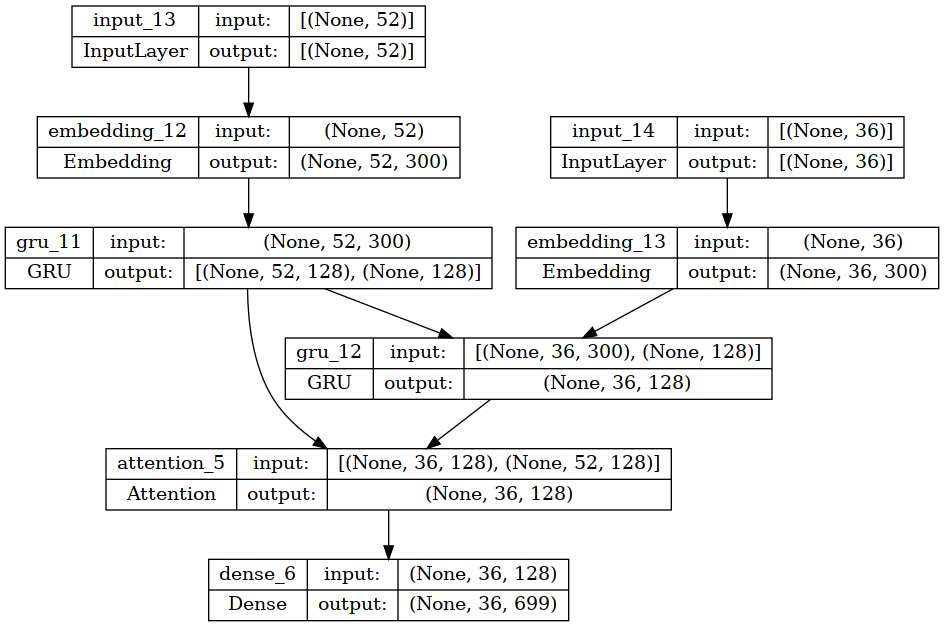

In [149]:
import pydot
utils.plot_model(model_gru, show_shapes=True)

In [150]:
model_gru.compile(optimizer = Adam(0.0005), loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
batch_size = 64
epochs = 100

In [151]:
checkpoint = ModelCheckpoint('best_model_weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min')

In [152]:
history = model_gru.fit([encoder_input_data, decoder_input_data], decoder_output_data, epochs = epochs, batch_size = batch_size, validation_split = 0.1, callbacks = [checkpoint])

Epoch 1/100


2023-08-14 12:41:21.296230: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3080 Ti" frequency: 1770 num_cores: 80 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11080" } environment { key: "cudnn" value: "8600" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory_size: 10196221952 bandwidth: 912096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


100/100 [==============================] - ETA: 0s - loss: 5.1628 - acc: 0.0941

2023-08-14 12:41:30.742015: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3080 Ti" frequency: 1770 num_cores: 80 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11080" } environment { key: "cudnn" value: "8600" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory_size: 10196221952 bandwidth: 912096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


100/100 [==============================] - 13s 86ms/step - loss: 5.1628 - acc: 0.0941 - val_loss: 4.7303 - val_acc: 0.1109
Epoch 2/100
100/100 [==============================] - 3s 27ms/step - loss: 4.6660 - acc: 0.1541 - val_loss: 4.4270 - val_acc: 0.1815
Epoch 3/100
100/100 [==============================] - 2s 16ms/step - loss: 4.3316 - acc: 0.1950 - val_loss: 4.1219 - val_acc: 0.2118
Epoch 4/100
100/100 [==============================] - 2s 16ms/step - loss: 4.0930 - acc: 0.2194 - val_loss: 3.9220 - val_acc: 0.2372
Epoch 5/100
100/100 [==============================] - 1s 11ms/step - loss: 3.9247 - acc: 0.2380 - val_loss: 3.7761 - val_acc: 0.2531
Epoch 6/100
100/100 [==============================] - 1s 10ms/step - loss: 3.7908 - acc: 0.2535 - val_loss: 3.6533 - val_acc: 0.2671
Epoch 7/100
100/100 [==============================] - 1s 11ms/step - loss: 3.6779 - acc: 0.2728 - val_loss: 3.5541 - val_acc: 0.2915
Epoch 8/100
100/100 [==============================] - 1s 13ms/step - los

100/100 [==============================] - 1s 7ms/step - loss: 1.9350 - acc: 0.5581 - val_loss: 2.5163 - val_acc: 0.4911
Epoch 63/100
100/100 [==============================] - 1s 7ms/step - loss: 1.9294 - acc: 0.5583 - val_loss: 2.5111 - val_acc: 0.4949
Epoch 64/100
100/100 [==============================] - 1s 8ms/step - loss: 1.9136 - acc: 0.5599 - val_loss: 2.5193 - val_acc: 0.4974
Epoch 65/100
100/100 [==============================] - 1s 7ms/step - loss: 1.9047 - acc: 0.5646 - val_loss: 2.5245 - val_acc: 0.4979
Epoch 66/100
100/100 [==============================] - 1s 8ms/step - loss: 1.8924 - acc: 0.5623 - val_loss: 2.5169 - val_acc: 0.4907
Epoch 67/100
100/100 [==============================] - 1s 7ms/step - loss: 1.8837 - acc: 0.5652 - val_loss: 2.5251 - val_acc: 0.4938
Epoch 68/100
100/100 [==============================] - 1s 7ms/step - loss: 1.8725 - acc: 0.5668 - val_loss: 2.5146 - val_acc: 0.4955
Epoch 69/100
100/100 [==============================] - 1s 7ms/step - loss:

In [153]:
best_epoch = np.argmin(history.history['val_loss'])
print("Best epoch:",str(best_epoch) + "/" + str(epochs))
print("loss:",history.history['loss'][best_epoch])
print("acc:",history.history['acc'][best_epoch])
print("val_loss:",history.history['val_loss'][best_epoch])
print("val_acc:",history.history['val_acc'][best_epoch])

Best epoch: 69/100
loss: 1.8602086305618286
acc: 0.5689834356307983
val_loss: 2.506953477859497
val_acc: 0.49757784605026245


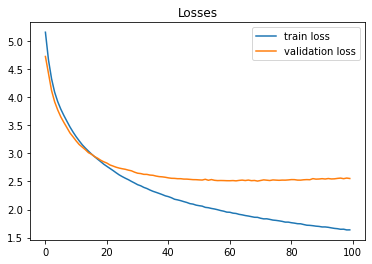

In [154]:
epochs_vals = range(0, epochs)
losses=history.history['loss']
val_losses=history.history['val_loss']
plt.title('Losses')
plt.plot(epochs_vals, losses, label='train loss')
plt.plot(epochs_vals, val_losses, label='validation loss')
plt.legend(loc='best')
plt.show()

In [169]:
def translate2(input_sentence):
    #Code input sentence
    input_sentence = input_sentence.replace('.', '').replace(',', '').replace('!','').replace('"','').replace('?','').lower()
    words = input_sentence.split(' ')
    coded_words =[input_word_index.get(word, input_word_index.get('<Unknown>')) for word in words]
    coded_words = pad_sequences([coded_words], maxlen = input_pad_len, padding = 'post')
    #Initialize decoder input with starting token
    decoder_input = np.reshape(target_word_index['<Start>'], (1,1))
    decoder_input = pad_sequences(decoder_input, target_pad_len, padding = 'post') #Pad decoder_input
    #Pass through the whole model sequentially:
    output_sentence = []
    for i in range(target_pad_len):
        decoder_output = model_gru.predict([coded_words, decoder_input], verbose = 0)
        next_word = np.argmax(decoder_output[0, i])
        if next_word == 0:
            break
        output_sentence.append(next_word)
        if i < target_pad_len - 1:
            decoder_input[0, i+1] = next_word
    return ' '.join(inverted_target_word_index[num] for num in output_sentence).replace(' - ', '-')

In [170]:
#LANG ZEIT REGION HOCH KOMMEN OST KOMMEN SONST REGION DEUTSCH STARK RUHIG AUCH TEILWEISE FREUNDLICH SONNE <End>
translate2('gleichzeitig weitet sich das hoch über der britannie weiter nach osten aus und beschert uns morgen in weiten teilen deutschlands ruhiges teilweise auch freundliches wetter')

'ZEIT HOCH HOCH KOMMEN KOMMEN KOMMEN MORGEN MORGEN FREUNDLICH FREUNDLICH <End>'